In [211]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster



In [213]:
df_original = pd.read_csv('df_eth_usd.csv')
df_original.drop(['Unnamed: 0', 'timestamp.1'], axis= 1, inplace=True  )


In [214]:
df_original.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
0,2019-11-27 07:45:00+00:00,146.0,146.0,146.0,146.0,0.01,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
1,2019-11-27 07:46:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
2,2019-11-27 07:47:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
3,2019-11-27 07:48:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
4,2019-11-27 07:49:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11


In [215]:
k = 5

# Create a copy of the original dataframe
df = df_original.copy()
df.rename(columns= {'close' : 'y'}, inplace=True)

# Shift the close price k times to create the lagged features
for i in range(1, k+1):
    col_name = f'x_{i}'
    df[col_name] = df['y'].shift(i)

# Drop the rows with missing values
df.dropna(inplace=True)

# Reorder the columns
cols = ['timestamp', 'y'] + [f'x_{i}' for i in range(1, k+1)]
df = df[cols]

# Reset the index
df.reset_index(drop=True, inplace=True)



In [216]:
df

,timestamp,y,x_1,x_2,x_3,x_4,x_5
0,2019-11-27 07:50:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
1,2019-11-27 07:51:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2,2019-11-27 07:52:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
3,2019-11-27 07:53:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
4,2019-11-27 07:54:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
...,...,...,...,...,...,...,...
191649,2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
191650,2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
191651,2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15
191652,2020-12-07 10:02:00+00:00,594.82,594.91,595.13,595.90,595.15,594.63


In [217]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [218]:
df.set_index('timestamp')

,y,x_1,x_2,x_3,x_4,x_5
timestamp,,,,,,
2019-11-27 07:50:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:51:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:52:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:53:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
2019-11-27 07:54:00+00:00,146.00,146.00,146.00,146.00,146.00,146.00
...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15


In [219]:
df.head()

,timestamp,y,x_1,x_2,x_3,x_4,x_5
0,2019-11-27 07:50:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
1,2019-11-27 07:51:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
2,2019-11-27 07:52:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
3,2019-11-27 07:53:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0
4,2019-11-27 07:54:00+00:00,146.0,146.0,146.0,146.0,146.0,146.0


Train dates : 0 --- 151653  (n=151654)
Test dates  : 151654 --- 191653  (n=40000)


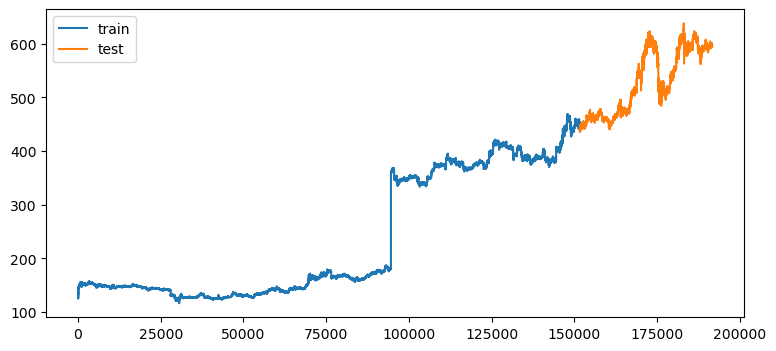

In [220]:
steps = 40000
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [221]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 151653] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-06 22:26:12 
Last fit date: 2023-03-06 22:27:02 
Skforecast version: 0.6.0 
Python version: 3.10.9 

In [222]:
steps = 40000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

151654    442.3876
151655    442.2360
151656    442.2979
151657    442.5890
151658    442.6058
Name: pred, dtype: float64

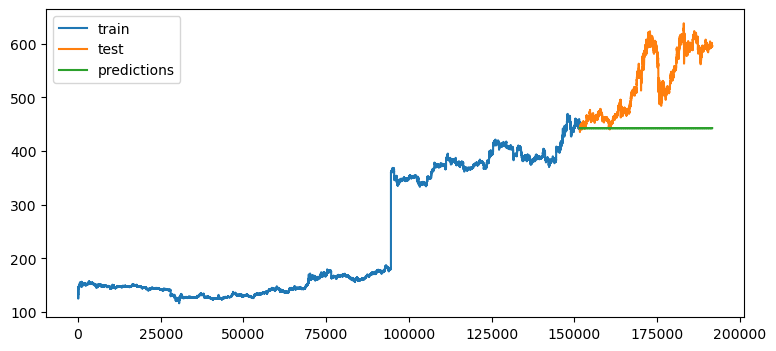

In [223]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [224]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 10997.78857531805


In [225]:
new_df = df.loc[110000:200000]

In [226]:
new_df

,timestamp,y,x_1,x_2,x_3,x_4,x_5
110000,2020-10-11 17:10:00+00:00,375.66,375.46,375.46,375.36,375.39,375.23
110001,2020-10-11 17:11:00+00:00,375.58,375.66,375.46,375.46,375.36,375.39
110002,2020-10-11 17:12:00+00:00,375.41,375.58,375.66,375.46,375.46,375.36
110003,2020-10-11 17:13:00+00:00,375.27,375.41,375.58,375.66,375.46,375.46
110004,2020-10-11 17:14:00+00:00,375.17,375.27,375.41,375.58,375.66,375.46
...,...,...,...,...,...,...,...
191649,2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
191650,2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
191651,2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15
191652,2020-12-07 10:02:00+00:00,594.82,594.91,595.13,595.90,595.15,594.63


In [227]:
new_df.set_index('timestamp')

,y,x_1,x_2,x_3,x_4,x_5
timestamp,,,,,,
2020-10-11 17:10:00+00:00,375.66,375.46,375.46,375.36,375.39,375.23
2020-10-11 17:11:00+00:00,375.58,375.66,375.46,375.46,375.36,375.39
2020-10-11 17:12:00+00:00,375.41,375.58,375.66,375.46,375.46,375.36
2020-10-11 17:13:00+00:00,375.27,375.41,375.58,375.66,375.46,375.46
2020-10-11 17:14:00+00:00,375.17,375.27,375.41,375.58,375.66,375.46
...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,595.90,595.15,594.63,595.15,596.40,596.04
2020-12-07 10:00:00+00:00,595.13,595.90,595.15,594.63,595.15,596.40
2020-12-07 10:01:00+00:00,594.91,595.13,595.90,595.15,594.63,595.15


Train dates : 110000 --- 171653  (n=61654)
Test dates  : 171654 --- 191653  (n=20000)


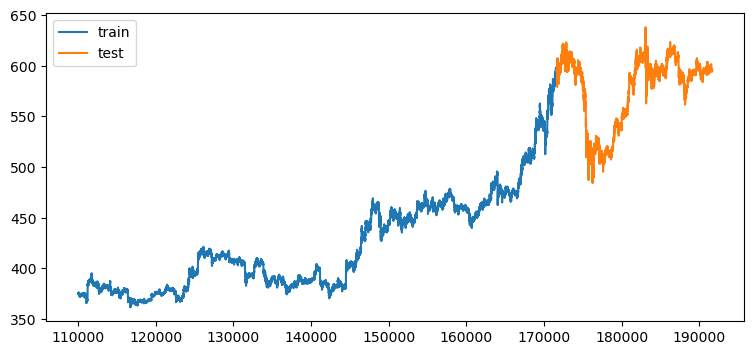

In [228]:
steps = 20000
data_train = new_df[:-steps]
data_test  = new_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [229]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [110000, 171653] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-06 22:28:38 
Last fit date: 2023-03-06 22:28:58 
Skforecast version: 0.6.0 
Python version: 3.10.9 

In [230]:
steps = 20000
predictions = forecaster.predict(steps=steps)
predictions.head(5)

171654    594.7481
171655    594.9837
171656    594.9168
171657    594.7820
171658    594.9770
Name: pred, dtype: float64

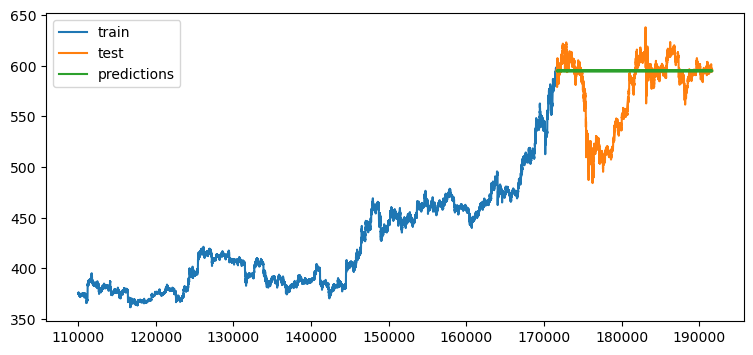

In [231]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Final Model

In [232]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [233]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

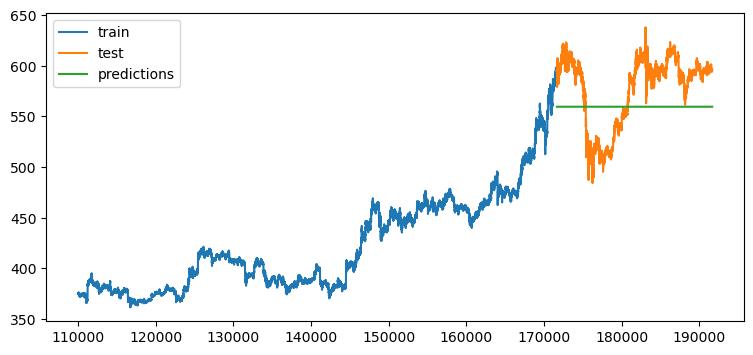

In [234]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [235]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1515.726897749165


In [236]:
df_original.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
0,2019-11-27 07:45:00+00:00,146.0,146.0,146.0,146.0,0.01,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
1,2019-11-27 07:46:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
2,2019-11-27 07:47:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
3,2019-11-27 07:48:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11
4,2019-11-27 07:49:00+00:00,146.0,146.0,146.0,146.0,0.00,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11


In [237]:

df_original['log_returns'] = np.log(df_original['close']) - np.log(df_original['open'])
#calculating standard deviation with rolling window of 50



In [238]:
df_original['log_returns'].describe()

count    1.916590e+05
mean     7.663595e-07
std      1.109064e-03
min     -4.742705e-02
25%     -3.987411e-04
50%      0.000000e+00
75%      4.021717e-04
max      4.876780e-02
Name: log_returns, dtype: float64

In [239]:
df_original['volatility'] = df_original['log_returns'].rolling(window=50).std()
df_original.dropna(inplace=True)

In [240]:
df_original.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month,log_returns,volatility
49,2019-11-27 08:34:00+00:00,125.03,125.03,125.03,125.03,0.0,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11,0.0,0.0
50,2019-11-27 08:35:00+00:00,125.03,125.03,125.03,125.03,0.0,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11,0.0,0.0
51,2019-11-27 08:36:00+00:00,125.03,125.03,125.03,125.03,0.0,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11,0.0,0.0
52,2019-11-27 08:37:00+00:00,125.03,125.03,125.03,125.03,0.0,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11,0.0,0.0
53,2019-11-27 08:38:00+00:00,125.03,125.03,125.03,125.03,0.0,binance,2022-07-09 10:42:47.613115+00:00,ETH_USDT,2019,11,0.0,0.0


In [241]:
df_original['volatility'].describe()

count    191610.000000
mean          0.000872
std           0.000689
min           0.000000
25%           0.000519
50%           0.000724
75%           0.001034
max           0.023042
Name: volatility, dtype: float64

In [242]:
df_original['timestamp'] = pd.to_datetime(df['timestamp'])

In [243]:
import seaborn as sns

In [244]:
k = 7

# Create a copy of the original dataframe
df_volatility = df_original.copy()
df_volatility.rename(columns= {'volatility' : 'y'}, inplace=True)

# Shift the close price k times to create the lagged features
for i in range(1, k+1):
    col_name = f'x_{i}'
    df_volatility[col_name] = df_volatility['y'].shift(i)

# Drop the rows with missing values
df_volatility.dropna(inplace=True)

# Reorder the columns
cols = ['timestamp', 'y'] + [f'x_{i}' for i in range(1, k+1)]
df_volatility = df_volatility[cols]

# Reset the index
df_volatility.reset_index(drop=True, inplace=True)


In [245]:
df_volatility.nunique()

timestamp    191598
y            190185
x_1          190184
x_2          190183
x_3          190182
x_4          190181
x_5          190180
x_6          190179
x_7          190178
dtype: int64

In [246]:
df_timestamp_3m = df_volatility.sort_values(by="timestamp",ascending=True).set_index("timestamp").last("3M")

In [247]:
df_timestamp_week = df_volatility.sort_values(by="timestamp",ascending=True).set_index("timestamp").last("7D")

In [248]:
df_timestamp_week

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7
timestamp,,,,,,,,
2020-11-30 10:04:00+00:00,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001324
2020-11-30 10:05:00+00:00,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293
2020-11-30 10:06:00+00:00,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293
2020-11-30 10:07:00+00:00,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292
2020-11-30 10:08:00+00:00,0.001284,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264
...,...,...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580,0.000580
2020-12-07 10:00:00+00:00,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580
2020-12-07 10:01:00+00:00,0.000589,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573


In [249]:
df_timestamp_3m

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7
timestamp,,,,,,,,
2020-10-01 00:00:00+00:00,0.001149,0.001135,0.001124,0.001123,0.001143,0.001220,0.001181,0.001181
2020-10-01 00:01:00+00:00,0.001149,0.001149,0.001135,0.001124,0.001123,0.001143,0.001220,0.001181
2020-10-01 00:02:00+00:00,0.001153,0.001149,0.001149,0.001135,0.001124,0.001123,0.001143,0.001220
2020-10-01 00:03:00+00:00,0.001158,0.001153,0.001149,0.001149,0.001135,0.001124,0.001123,0.001143
2020-10-01 00:04:00+00:00,0.001108,0.001158,0.001153,0.001149,0.001149,0.001135,0.001124,0.001123
...,...,...,...,...,...,...,...,...
2020-12-07 09:59:00+00:00,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580,0.000580
2020-12-07 10:00:00+00:00,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580
2020-12-07 10:01:00+00:00,0.000589,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573


Train dates : 2020-10-01 00:00:00+00:00 --- 2020-11-30 10:03:00+00:00  (n=87004)
Test dates  : 2020-11-30 10:04:00+00:00 --- 2020-12-07 10:03:00+00:00  (n=10080)


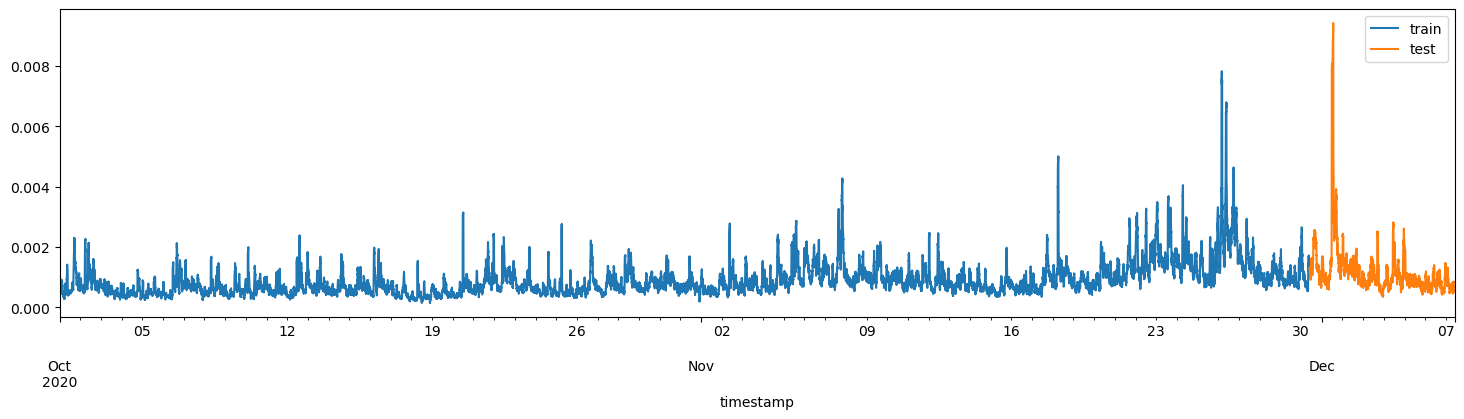

In [250]:
steps = 10080
data_train = df_timestamp_3m[:-steps]
data_test  = df_timestamp_3m[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(18, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [281]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags = 8
             )

forecaster.fit(y=data_train['y'])

In [282]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)
predictions.nunique()

1

In [283]:
predictions = pd.DataFrame(predictions)

In [284]:


predictions = predictions.reset_index()
predictions

,index,pred
0,8,0.001143
1,9,0.001143
2,10,0.001143
3,11,0.001143
4,12,0.001143
5,13,0.001143
6,14,0.001143
7,15,0.001143
8,16,0.001143
9,17,0.001143


In [285]:
df_pred = df_timestamp_week.copy()
df_pred.reset_index(inplace=True)
df_pred.head()

,timestamp,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7
0,2020-11-30 10:04:00+00:00,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001324
1,2020-11-30 10:05:00+00:00,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293
2,2020-11-30 10:06:00+00:00,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293
3,2020-11-30 10:07:00+00:00,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292
4,2020-11-30 10:08:00+00:00,0.001284,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264


In [286]:
df_pred['predicted'] = predictions['pred']
df_pred.head()

,timestamp,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,predicted
0,2020-11-30 10:04:00+00:00,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001324,0.001143
1,2020-11-30 10:05:00+00:00,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001143
2,2020-11-30 10:06:00+00:00,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001143
3,2020-11-30 10:07:00+00:00,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001143
4,2020-11-30 10:08:00+00:00,0.001284,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001143


In [287]:
df_pred['predicted'].nunique()

1

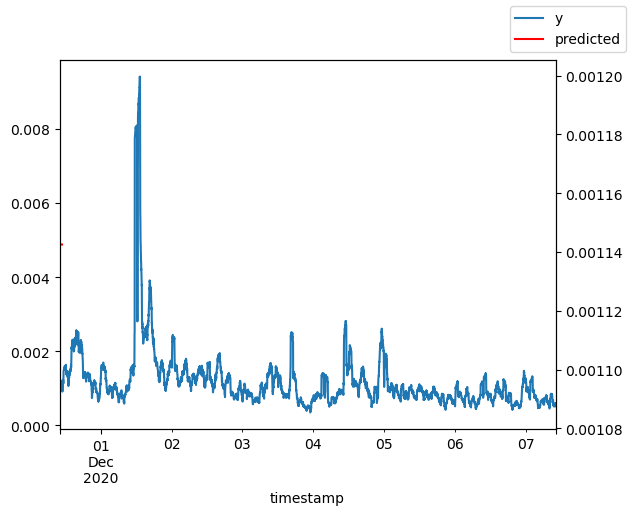

In [288]:
ax = df_pred.plot(x="timestamp", y="y", legend=False)
ax2 = ax.twinx()
df_pred.plot(x="timestamp", y="predicted", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [289]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = df_pred['predicted']
            )

print(f"Test error (mse): {error_mse}")

ValueError: Input contains NaN.

In [ ]:
print("%.8f" % error_mse)

0.00000083


## BackTesting

In [291]:
# Backtesting
# ==============================================================================
steps = 10080
n_backtesting = 10080*5 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df_timestamp_3m['y'],
                                    initial_train_size = len(df_timestamp_3m) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 46684
Number of observations used for backtesting: 50400
    Number of folds: 5
    Number of steps per fold: 10080

Data partition in fold: 0
    Training:   2020-10-01 00:00:00+00:00 -- 2020-11-02 10:03:00+00:00  (n=46684)
    Validation: 2020-11-02 10:04:00+00:00 -- 2020-11-09 10:03:00+00:00  (n=10080)
Data partition in fold: 1
    Training:   2020-10-01 00:00:00+00:00 -- 2020-11-09 10:03:00+00:00  (n=56764)
    Validation: 2020-11-09 10:04:00+00:00 -- 2020-11-16 10:03:00+00:00  (n=10080)
Data partition in fold: 2
    Training:   2020-10-01 00:00:00+00:00 -- 2020-11-16 10:03:00+00:00  (n=66844)
    Validation: 2020-11-16 10:04:00+00:00 -- 2020-11-23 10:03:00+00:00  (n=10080)
Data partition in fold: 3
    Training:   2020-10-01 00:00:00+00:00 -- 2020-11-23 10:03:00+00:00  (n=76924)
    Validation: 2020-11-23 10:04:00+00:00 -- 2020-11-30 10:03:00+00:00  (n=10080)
Dat

In [292]:
predictions_backtest = predictions_backtest.reset_index()


In [297]:
predictions_backtest['pred']

0        0.000841
1        0.000841
2        0.000841
3        0.000841
4        0.000841
           ...   
50395    0.001143
50396    0.001143
50397    0.001143
50398    0.001143
50399    0.001143
Name: pred, Length: 50400, dtype: float64

In [294]:
df_pred['predicted_backtest'] = predictions_backtest['pred']

In [304]:

# Create a new dataframe with averages
df_avg = predictions_backtest['pred'].rolling(window=5).mean()[4::5]



In [306]:
df_avg = df_avg.reset_index()
df_avg

,index,pred
0,4,0.000841
1,9,0.000841
2,14,0.000841
3,19,0.000841
4,24,0.000841
...,...,...
10075,50379,0.001143
10076,50384,0.001143
10077,50389,0.001143
10078,50394,0.001143


In [307]:
df_pred['predicted_backtest'] = df_avg['pred']
df_pred

,timestamp,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,predicted,predicted_backtest
0,2020-11-30 10:04:00+00:00,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001324,0.001143,0.000841
1,2020-11-30 10:05:00+00:00,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001293,0.001143,0.000841
2,2020-11-30 10:06:00+00:00,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001293,0.001143,0.000841
3,2020-11-30 10:07:00+00:00,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001292,0.001143,0.000841
4,2020-11-30 10:08:00+00:00,0.001284,0.001257,0.001251,0.001253,0.001261,0.001267,0.001264,0.001264,0.001143,0.000841
...,...,...,...,...,...,...,...,...,...,...,...
10075,2020-12-07 09:59:00+00:00,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580,0.000580,NaN,0.001143
10076,2020-12-07 10:00:00+00:00,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,0.000580,NaN,0.001143
10077,2020-12-07 10:01:00+00:00,0.000589,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,0.000573,NaN,0.001143
10078,2020-12-07 10:02:00+00:00,0.000585,0.000589,0.000509,0.000530,0.000529,0.000575,0.000575,0.000572,NaN,0.001143


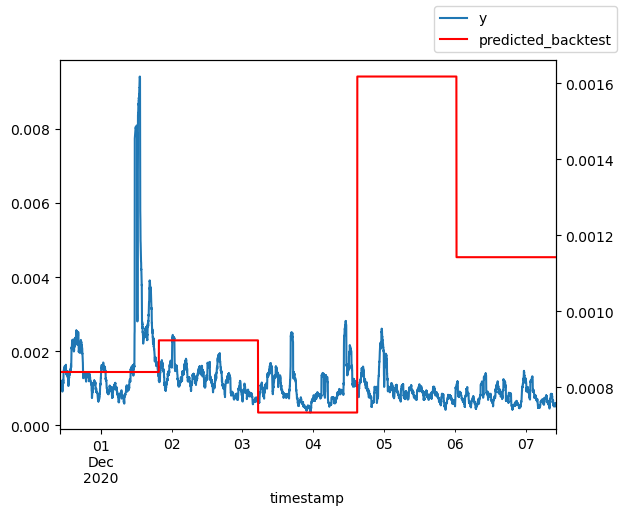

In [308]:
ax = df_pred.plot(x="timestamp", y="y", legend=False)
ax2 = ax.twinx()
df_pred.plot(x="timestamp", y="predicted_backtest", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [300]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.997984
1,lag_2,0.001795
2,lag_3,0.000222
3,lag_4,0.000000
4,lag_5,0.000000
5,lag_6,0.000000
6,lag_7,0.000000
7,lag_8,0.000000
